In [2]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions
using BenchmarkTools;

In [3]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end

# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "xbar", sm, ordering)
    else
        return 0
    end
end;

In [14]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
#=
function DSNB_integrand(E::Float64, z0::Float64, z::Float64, i::Int, nubar::Bool, ordering::String, bh_frac::String, normchoice::Float64)
    # c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end
=#

function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

DSNB(E::Float64, z0::Float64, i::Int, nubar::Bool, ordering::String, bh_frac::String, normchoice::Float64) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1];

In [9]:
# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
leff = extrapolate(leff_ne, 0.0)

function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end;

In [10]:
# Invisible decay

function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-3)[1]
end

#=
function DSNB_idecay_test(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    L = 1/(4.68e28 * α / E)
    return quadgk(u -> 1/(1+z0) * DSNB_integrand(E, z0, u*L, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, u*L)*L, z0/L, 5/L, rtol=1e-3)[1]
end
=#

function DSNB_idecay_νe(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [11]:
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end;

In [12]:
# 2ν SH treatment (but QD for IO 2 → 1)

# Here we take m_j > m_i
function qcontrib_2ν(E, z0, z, j, jbar, i, ibar, αj, ordering, bh_frac, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 2 && i == 1
        if jbar != ibar
            return 0.0
        else
            Ers = E*(1+z)/(1+z0)
            qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
            return qnorm * (c0/Hubble(z))*DSNB_idecay(Ers, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj/Ers)
        end
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end

        Ers = E*(1+z)/(1+z0)

        qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
        integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj * 0.5/Eprime) * ψSH(Eprime, Ers, hc)
        Emax = Ers + 50

        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_2ν(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 3, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 3, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_2ν_alt(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, 0, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, 0, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν1 to be stable and for IO we take ν2 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 1, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 1, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end

# daughter specifies the state the heaviest mass state decays into in our 2ν framework

function DSNB_vdecay_2ν_νe(E, α, daughter, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

function DSNB_vdecay_2ν_νe_alt(E, α, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_alt(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν_alt(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν_alt(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;

In [30]:
es_dsnb = range(15, 35, 100);

In [81]:
dsnb_nodecay = DSNB_idecay_νe.(es_dsnb, 0, 0, 0, 0, true, "IO", "41", SNRnorm)
dsnb_vdecay = DSNB_vdecay_2ν_νe.(es_dsnb, 10^(-24), 1, true, "IO", "41", SNRnorm)
dsnb_nodecay_f21 = DSNB_idecay_νe.(es_dsnb, 0, 0, 0, 0, true, "IO", "21", SNRnorm)

dsnb_nodecay_low, dsnb_nodecay_high = DSNB_idecay_νe.(es_dsnb, 0, 0, 0, 0, true, "IO", "41", SNRnorm_low), DSNB_idecay_νe.(es_dsnb, 0, 0, 0, 0, true, "IO", "41", SNRnorm_high);

In [78]:
Δ = mass_neutron - mass_proton
# Cross section
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

function binned_convolved_flux(emin, emax, decay)
    σnorm = quadgk(E -> σIBD(E), emin, emax, rtol=1e-3)[1]
    if decay == false
        ϕint = quadgk(E -> σIBD(E)*DSNB_idecay_νe(E, 0, 0, 0, 0, true, "IO", "41", SNRnorm), emin, emax, rtol=1e-3)[1]
    else
        ϕint = quadgk(E -> σIBD(E)*DSNB_vdecay_2ν_νe(E, 10^(-24), 1, true, "IO", "41", SNRnorm), emin, emax, rtol=1e-3)[1]
    end
    return ϕint/σnorm
end;

In [84]:
superk_limits

6-element Vector{Float64}:
 0.2031055900621117
 0.2031055900621117
 0.2031055900621117
 0.05776397515527942
 0.05776397515527942
 0.05776397515527942

In [54]:
superk_dsnb = readdlm("Data/SuperK_DSNB_90CL.csv", ',')
superk_es, superk_limits = superk_dsnb[:,1], superk_dsnb[:,2]

superk90cl_nonextrap = Interpolations.interpolate((superk_es,), superk_limits, Gridded(Linear()))
superk90cl = extrapolate(superk90cl_nonextrap, 0.0);

In [47]:
0.203106/(25.2679 - 17.3214)

0.025559176996161833

In [86]:
@time binned_convolved_flux(25.375, 31.286, true)

  7.672528 seconds (6.20 M allocations: 291.213 MiB, 8.74% gc time)


0.018313873400065878

In [ ]:
binned_convolved_flux(25.2679, 33, false)

In [75]:
0.38492858359003185/(25.2679 - 17.3214)

0.04844001555276308

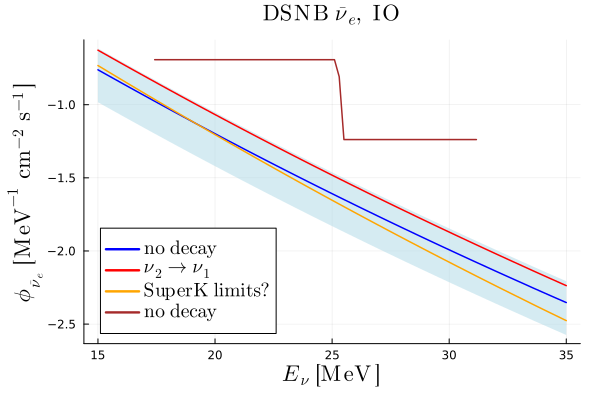

In [82]:
plot(es_dsnb,
    log10.(dsnb_nodecay_low),
    alpha=0,
    fillrange=log10.(dsnb_nodecay_high),
    fillalpha=0.5,
    c=:lightblue,
    label=false
)
plot!(
    es_dsnb,
    [log10.(dsnb_nodecay) log10.(dsnb_vdecay) log10.(dsnb_nodecay_f21) log10.(superk90cl.(es_dsnb))],
    c=[:blue :red :orange :brown :black],
    lw=[1.5 1.5 1.5 1.5 1.5],
    ls=[:solid :solid :solid :solid :solid],
    alpha=[1 1 1 1 1],
    label=[L"\mathrm{no~decay}" L"\nu_2 \to \nu_1" L"\mathrm{SuperK~limits?}"],
    title=L"\mathrm{DSNB}~\bar{\nu}_e,\mathrm{~IO}",
    ylabel=L"\phi_{\bar{\nu}_e}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=13,
    margins=3Plots.mm,
)